In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')

In [2]:
counting_all_reporting_worse_alignment = False
allpenalty = ['bowtie','bwa','minimap','mapper']
pairing_bonus = 500 # bonus giving to paired-end alignment
speciesset = {
    'Bactor':['am_BaFr']#['af_BaCa','bf_BaFr','cx_BaTh','cx_BaXy','cx_BaSt']
}
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0',
    'mapper':'#ca0020','mapper 16mer':'#fddbc7',
    'mapper 20mer':'#f4a582','mapper 24mer':'#d6604d',
        'bowtie2 all':'#2166ac','minimap2 all':'#67a9cf','bwa all':'#d1e5f0',
    'strobealign':'#000000',
    'last':'#252525',
    'strobealign all':'#053061',
     'mapper no gapped-xmer':'#f4a582',
    }

for penalty in allpenalty:
    folder = 'SNP_model_multi/%s/'%(penalty)
    toolset = [
        'mapper1.nogap',
        'mapper1', 
    'mapper1.kmer16','mapper1.kmer20','mapper1.kmer24',
        'strobealign.all','strobealign','last',
             'bowtie.all','minimap.all','bwa.all','bowtie','minimap','bwa', 
              ]
    print('process',folder)
    for species in speciesset:
        genomeset = speciesset[species]
        print(species,genomeset)
        # process
        for tool in toolset:#toolset[:1]:#toolset[-1:]:
            score_tag = 'AS'
            if tool == 'mapper1':
                score_tag = 'CAS'
            allsam = ''
            allsam1 = ''
            subsammapper = ''
            samcomparemapper = ''
            alignmentsum = ''
            alignment_allworse = ''
            alignment_allbetter = ''
            alignment_allsame = ''
            alignmentsum = ''
            alignment_allworse_all_suboptimal = ''
            alignment_allworse_single_miss = ''
            alignment_allworse = ''
            
            allsam = pd.read_csv('%s/all_1.fastq_%s.%s.sam'%(folder,species,tool), 
                             sep='\t',usecols=[0, 1, 2,3,4,5],header=0, 
                             names=['readID', 'Direction','CHRmerge', 'POSmerge','Tagmerge','Scoremerge'],comment='@')
#             allsam = allsam[allsam['readID']=='af_BaCa_SL-NXA:H2H7HBGX3170812:H2H7HBGX3:1:12305:8912:19764']
##             allsam = allsam.sort_values(['readID','CHRmerge','POSmerge'])
            allsam['Tagmerge'] = [x.split(':')[0] for x in allsam['Tagmerge']]
            allsam=allsam.drop_duplicates(['readID','Direction', 'CHRmerge', 'POSmerge','Scoremerge'])
#             allsam['fastq']=['_'.join(x.split('_')[:2]) for x in allsam['readID']]
            allsam['newfastq']=['_'.join(x.split('_')[:2]) for x in allsam['CHRmerge']]
            allsam['Direction'] = [str(x&16>0) for x in allsam['Direction']]
            allsam['readIDnew'] = allsam['readID']+ ':D' +allsam['Direction']
            allsam['readIDCHRPOS']=allsam['readID']+ allsam['CHRmerge'] + [str(x) for x in allsam['POSmerge']]
            for genome in genomeset[:1]:
                allresultset = pd.DataFrame()
                allsam1 = allsam#[allsam['fastq']==genome]
                allsam1.index = range(0,allsam1.shape[0])
                allsam1['all_sum']=0
                i = 0
                while i < allsam1.shape[0]:
                    readID = allsam1.loc[i,'readID']
                    if i < allsam1.shape[0]-1 and allsam1.loc[i,'readID'] == allsam1.loc[i+1,'readID']:
                        if allsam1.loc[i,'Direction']!=allsam1.loc[i+1,'Direction'] and \
                        allsam1.loc[i,'Tagmerge']==score_tag and allsam1.loc[i+1,'Tagmerge']==score_tag:
                            totalscore = allsam1.loc[i,'Scoremerge'] + allsam1.loc[i+1,'Scoremerge'] + pairing_bonus
                            allsam1.loc[i,'all_sum'] = totalscore
                            allsam1.loc[i+1,'all_sum'] = totalscore
                            i += 2
                        else:
                            allsam1.loc[i,'all_sum'] = allsam1.loc[i,'Scoremerge']
                            i += 1
                    else:
                        allsam1.loc[i,'all_sum'] = allsam1.loc[i,'Scoremerge']
                        i += 1

                filename = glob.glob('%s/%s*_1.fastq_%s.%s.sam'%(folder,genome,species,tool))[0]
                subsammapper = pd.read_csv(filename, 
                                         sep='\t',usecols=[0, 1, 2,3,4,5],header=0, 
                                         names=['readID', 'Direction','CHR', 'POS','Tag','Score'],comment='@')
#                 subsammapper = subsammapper[subsammapper['readID']=='af_BaCa_SL-NXA:H2H7HBGX3170812:H2H7HBGX3:1:12305:8912:19764']
##                 subsammapper = subsammapper.sort_values(['readID','CHR','POS'])
                subsammapper['Tag'] = [x.split(':')[0] for x in subsammapper['Tag']]
                subsammapper=subsammapper.drop_duplicates(['readID','Direction', 'CHR', 'POS','Score'])
                subsammapper['Direction'] = [str(x&16>0) for x in subsammapper['Direction']]
                subsammapper['readIDnew'] = subsammapper['readID']+ ':D' +subsammapper['Direction']
                total_reads = len(subsammapper['readIDnew'].unique())
                total_alignments = subsammapper.shape[0]
                print('total_reads',total_reads)
                print('total_alignments',total_alignments)
                subsammapper['readIDCHRPOS']=subsammapper['readID'] + subsammapper['CHR'] + [
                    str(x) for x in subsammapper['POS']]
                subsammapper.index = range(0,subsammapper.shape[0])
                subsammapper['single_sum']=0
                i = 0
                while i < subsammapper.shape[0]:
                    readID = subsammapper.loc[i,'readID']
                    if i < subsammapper.shape[0]-1 and subsammapper.loc[i,'readID'] == subsammapper.loc[i+1,'readID']:
                        # maybe a pair
                        if subsammapper.loc[i,'Direction']!=subsammapper.loc[i+1,'Direction'] and subsammapper.loc[i,'Tag']==score_tag and subsammapper.loc[i+1,'Tag']==score_tag:
                            # a pair -> add pairing_bonus
                            totalscore = subsammapper.loc[i,'Score'] + subsammapper.loc[i+1,'Score'] + pairing_bonus
                            subsammapper.loc[i,'single_sum'] = totalscore
                            subsammapper.loc[i+1,'single_sum'] = totalscore
                            i += 2
                        else:
                            # not a pair
                            subsammapper.loc[i,'single_sum'] = subsammapper.loc[i,'Score']
                            i += 1
                    else:
                        # not a pair
                        subsammapper.loc[i,'single_sum'] = subsammapper.loc[i,'Score']
                        i += 1
                allsam1.index = allsam1['readIDnew']
                subsammapper.index = subsammapper['readIDnew']
                # compare results
                samcomparemapper = allsam1.merge(subsammapper,left_on = 'readIDCHRPOS',right_on = 'readIDCHRPOS',how = 'outer')
                samcomparemapper['readIDnew']=samcomparemapper['readIDnew_x']
                samcomparemapper.loc[samcomparemapper['readIDnew'].isna(),'readIDnew'] = samcomparemapper.loc[samcomparemapper['readIDnew'].isna(),'readIDnew_y']
                samcomparemapper.loc[samcomparemapper['single_sum'].isna(),'single_sum']=-1000
                samcomparemapper.loc[samcomparemapper['all_sum'].isna(),'all_sum']=-1000
                samcomparemapperdiff = samcomparemapper[samcomparemapper['single_sum']!=samcomparemapper['all_sum']]
                samcomparemapper = samcomparemapper[samcomparemapper['readIDnew'].isin(samcomparemapperdiff['readIDnew'])]

                bestalignment = pd.DataFrame(samcomparemapper.groupby(['readIDnew'])['all_sum'].max())
                bestalignment2 = pd.DataFrame(samcomparemapper.groupby(['readIDnew'])['single_sum'].max())
                bestalignment = bestalignment.merge(bestalignment2,left_index=True,right_index=True,how = 'outer')
                bestalignment['best_best'] = [max(x,y) for (x,y) in zip(bestalignment['single_sum'],bestalignment['all_sum'])]
                bestalignment.columns = ['all_best','single_best','best_best']
                # count all subalignments
                # counting_all_reporting_worse_alignment -> True
                samcomparemapper = samcomparemapper.merge(bestalignment,left_on ='readIDnew',
                                                         right_index=True,how = 'outer')
                samcomparemapper_best = samcomparemapper[(samcomparemapper['all_sum']>=samcomparemapper['best_best']) | 
                                                       (samcomparemapper['single_sum']>=samcomparemapper['best_best']) ]
                print('all alignments',samcomparemapper.shape,'best alignments',samcomparemapper_best.shape
                     )
                alignmentsum = pd.DataFrame(samcomparemapper.groupby('readIDnew')['readIDnew'].count())
#                 print('samcomparemapper',samcomparemapper.shape)
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum.columns = ['total alignments']
                alignmentsum.reset_index(inplace=True)
                alignmentsumbest = pd.DataFrame(samcomparemapper_best.groupby('readIDnew')['readIDnew'].count())
                alignmentsumbest.columns = ['total_best_alignments']
                alignmentsumbest.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsumbest,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                samcomparemapper['all_lessthan_all_best']=0
                samcomparemapper['all_lessthan_single_best']=0
                samcomparemapper['all_equal_best_best']=0
                samcomparemapper['single_equal_best_best']=0
                samcomparemapper['all_better_single_best']=0
                # allsam reads that are suboptimal compared to best allsam reads
                samcomparemapper.loc[(samcomparemapper['all_sum']<samcomparemapper['all_best']) &(
                samcomparemapper['all_sum'] > -1000),'all_lessthan_all_best']=1
                # all sam reads that are suboptimal compared the best singlesam reads
                samcomparemapper.loc[(samcomparemapper['all_sum']<samcomparemapper['single_best'])&(
                samcomparemapper['all_sum'] > -1000),'all_lessthan_single_best']=1
                # all_equal_best_best have the best score
                samcomparemapper.loc[samcomparemapper['all_sum']>=samcomparemapper['best_best'],'all_equal_best_best']=1
                # single_equal_best_best have the best score 
                samcomparemapper.loc[samcomparemapper['single_sum']>=samcomparemapper['best_best'],'single_equal_best_best']=1
                # all sam reads that are better than single sam read
                samcomparemapper.loc[samcomparemapper['all_sum']>samcomparemapper['single_best'],'all_better_single_best']=1
                # all_better_single_best should also have the best score
                samcomparemapper.loc[samcomparemapper['all_sum']<samcomparemapper['best_best'],'all_better_single_best']=0
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_better_single_best'].sum())
                alignmentsum1.columns = ['all_better_single_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['single_equal_best_best'].sum())
                alignmentsum1.columns = ['single_equal_best_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_equal_best_best'].sum())
                alignmentsum1.columns = ['all_equal_best_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_lessthan_all_best'].sum())
                alignmentsum1.columns = ['all_lessthan_all_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_lessthan_single_best'].sum())
                alignmentsum1.columns = ['all_lessthan_single_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                # total bset alignments = total alignments - suboptimal alignments, second estimation, should be smaller than total_best_alignments
                alignmentsum['total_best_alignments2'] = alignmentsum['total alignments'] - alignmentsum['all_lessthan_all_best count']
                alignmentsum.to_csv(filename.replace('.sam','.sum'),sep='\t',index = False)
                # showing all suboptimal results: including single sam good ones missing, and allsam output bad ones
                # but bowtie all includes bad alignment -> counting_all_reporting_worse_alignment set to false
                alignmentsum2 = alignmentsum[alignmentsum['total alignments']>(alignmentsum['all_equal_best_best count'])][
                    alignmentsum['single_equal_best_best count']>0
                ]
                print('all',samcomparemapper.shape,alignmentsum.shape,alignmentsum2.shape,penalty,tool,species,genome)
                alignment_allworse = alignmentsum[alignmentsum['total alignments']>(alignmentsum['all_equal_best_best count'])][
                    alignmentsum['single_equal_best_best count']>0
                ]
                alignment_allbetter = alignmentsum[alignmentsum['total alignments']>(alignmentsum['all_equal_best_best count'])][
                                    alignmentsum['single_equal_best_best count']==0
                                ]
                alignment_allsame = alignmentsum[alignmentsum['total alignments']==(alignmentsum['all_equal_best_best count'])]
                print('alignment_allworse',alignment_allworse.shape,
                    'alignment_allbetter',alignment_allbetter.shape,
                     'alignment_allsame',alignment_allsame.shape,
                     'total reads',alignmentsum.shape)
                alignment_allworse_single_miss = alignment_allworse[alignment_allworse['total alignments']>
                                                                   alignment_allworse['all_equal_best_best count']+
                                                                   alignment_allworse['all_lessthan_all_best count']
                                                                  ]
                alignment_allworse_all_suboptimal = alignment_allworse[alignment_allworse['total alignments']==
                                                                   alignment_allworse['all_equal_best_best count']+
                                                                   alignment_allworse['all_lessthan_all_best count']
                                                                  ]
                print('alignment_allworse_all_suboptimal',alignment_allworse_all_suboptimal.shape,
                    'alignment_allworse_single_miss',alignment_allworse_single_miss.shape,
                     'alignment_allworse',alignment_allworse.shape)
                allresult = pd.DataFrame(
                {
                    'penalty':penalty,
                    'tool':tool,
                    'species':species,
                    'genome':genome,
                    'alignment_allworse_all_suboptimal':alignment_allworse_all_suboptimal.shape[0],
                    'alignment_allworse_single_miss':alignment_allworse_single_miss.shape[0],
                    'alignment_allbetter':alignment_allbetter.shape[0],
                    'total_reads':total_reads,#alignmentsum.shape[0],
                    # divide by total best alignments
                    'alignment_allworse_all_suboptimalper':sum(alignment_allworse_all_suboptimal['all_lessthan_all_best count']/alignment_allworse_all_suboptimal['total_best_alignments']),
                    # dovide by total best alignments
                    'alignment_allworse_single_missper':sum((alignment_allworse_single_miss['total alignments']-
                                                            alignment_allworse_single_miss['all_lessthan_all_best count']-
                                                            alignment_allworse_single_miss['all_equal_best_best count'])/alignment_allworse_single_miss['total_best_alignments']),
                    # divide by total best alignments
                    'alignment_allbetterper':sum(alignment_allbetter['all_better_single_best count']/alignment_allbetter['total_best_alignments']),
                    'total_alignments_reads_with_problem':sum(alignmentsum['total alignments']) - sum(alignment_allsame['total alignments'])  - sum(alignment_allbetter['total alignments']),
                    'total_alignments':total_alignments,#sum(alignmentsum['total alignments']),
                    'total_best_alignments':sum(alignmentsum['total_best_alignments']),
                    'total_best_alignments2':sum(alignmentsum['total_best_alignments2'])
                }, index=[0]
                )
                allresultset = allresultset.append(allresult)
                allresultset.to_csv('SNP_model_multi/comparesum.txt',sep='\t',index=False,mode = 'a',header=False)
                print(allresultset)



process SNP_model_multi/bowtie/
Bactor ['am_BaFr']
total_reads 3208056
total_alignments 3208807
all alignments (14551606, 22) best alignments (14328698, 22)
all (14551606, 27) (2411457, 9) (4967, 9) bowtie mapper1.nogap Bactor am_BaFr
alignment_allworse (4967, 9) alignment_allbetter (71599, 9) alignment_allsame (2334891, 9) total reads (2411457, 9)
alignment_allworse_all_suboptimal (1, 9) alignment_allworse_single_miss (4966, 9) alignment_allworse (4967, 9)
  penalty           tool species   genome  alignment_allworse_all_suboptimal  \
0  bowtie  mapper1.nogap  Bactor  am_BaFr                                  1   

   alignment_allworse_single_miss  alignment_allbetter  total_reads  \
0                            4966                71599      3208056   

   alignment_allworse_all_suboptimalper  alignment_allworse_single_missper  \
0                                   1.0                       10377.783333   

   alignment_allbetterper  total_alignments_reads_with_problem  \
0          

In [6]:
%reset -f

In [10]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')
allresultset=pd.read_csv('SNP_model_multi/comparesum.txt',sep='\t')
allresultset['tool'] = [x.replace('.',' ').replace('mapper1 nogap','mapper no gapped-xmer').replace('kmer20','20mer').replace('kmer24','24mer').replace('kmer16','16mer').replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2') for x in allresultset['tool']]
allresultset.loc[allresultset['alignment_allworse_all_suboptimal']==0,'alignment_allworse_all_suboptimal']=1
allresultset['alignment_allworse_all_suboptimal_reads']=allresultset['alignment_allworse_all_suboptimal']/allresultset['total_reads']
allresultset['alignment_allworse_single_miss_reads']=allresultset['alignment_allworse_single_miss']/allresultset['total_reads']
allresultset.loc[:,['alignment_allworse_single_miss_reads','alignment_allworse_all_suboptimal_reads','penalty','tool',
                   'total_reads']].to_csv('SNP_model_multi/comparesumshort.txt',sep='\t',index = False)
allresultset.loc[:,['alignment_allworse_single_miss_reads','alignment_allworse_all_suboptimal_reads','penalty','tool',
                   'total_reads']]


,alignment_allworse_single_miss_reads,alignment_allworse_all_suboptimal_reads,penalty,tool,total_reads
0,0.003079,7.347603e-01,bowtie,bowtie2 all,3209652
1,0.519650,1.561310e-04,bowtie,minimap2 all,3215249
2,0.518471,2.636073e-04,bowtie,bwa all,3224494
3,0.520867,5.608487e-06,bowtie,bowtie2,3209422
4,0.519728,1.564420e-04,bowtie,minimap2,3215249
5,0.520111,7.691196e-05,bowtie,bwa,3224466
6,0.003403,7.438259e-01,bwa,bowtie2 all,3217870
7,0.519360,1.523977e-04,bwa,minimap2 all,3215271
8,0.518491,2.331876e-04,bwa,bwa all,3224871
9,0.520960,4.972514e-06,bwa,bowtie2,3217688


bowtie
bwa
minimap
mapper


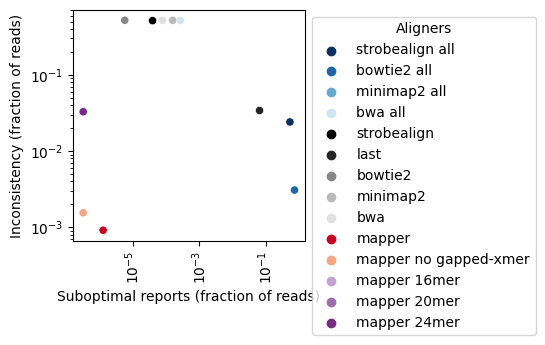

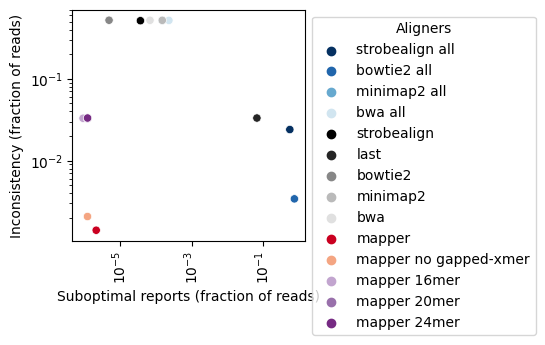

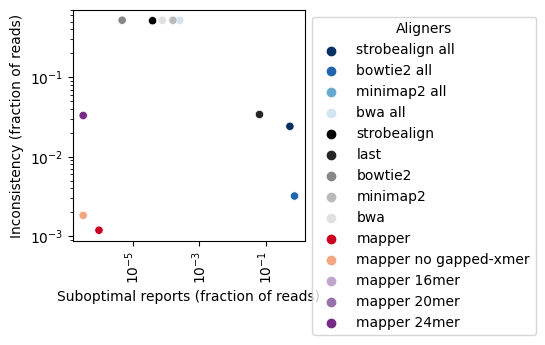

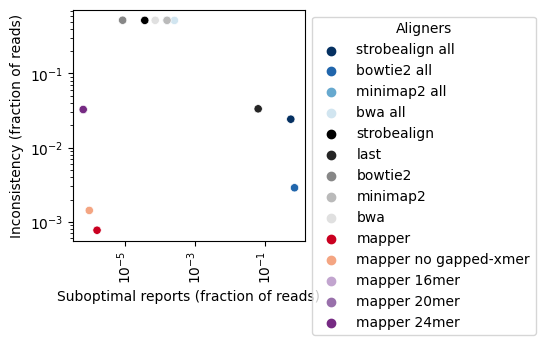

In [12]:
#plot
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0',
    'mapper':'#ca0020',
        'bowtie2 all':'#2166ac','minimap2 all':'#67a9cf','bwa all':'#d1e5f0',
    'strobealign':'#000000',
    'last':'#252525',
    'strobealign all':'#053061',
     'mapper no gapped-xmer':'#f4a582',
    'mapper 16mer':'#c2a5cf',
        'mapper 24mer':'#762a83',
         'mapper 20mer':'#9970ab',
        'No gapped k-mer unmatched':'#e66101',
    }


legend_order = [  'strobealign all','bowtie2 all','minimap2 all','bwa all','strobealign','last','bowtie2','minimap2',
                'bwa', 
                'mapper','mapper no gapped-xmer','mapper 16mer','mapper 20mer','mapper 24mer',]

#plot
allresultset=allresultset[allresultset['tool'].isin(legend_order)]
allpenalty = ['bowtie','bwa','minimap','mapper']
for penalty in allpenalty:
    print(penalty)
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3,3))
    sns.scatterplot(data = allresultset[allresultset['penalty']==penalty],
               x='alignment_allworse_all_suboptimal_reads',y='alignment_allworse_single_miss_reads',hue='tool',
                palette=palette_set,hue_order = legend_order)
    axs.set_xlabel('Aligners') 
    axs.set_ylabel('Inconsistency (fraction of reads)')
    axs.set_xlabel('Suboptimal reports (fraction of reads)')
    axs.set(yscale="log")
    axs.set(xscale="log")
    plt.sca(axs)
    plt.legend(title = 'Aligners', bbox_to_anchor=(1.0, 1.0))   
    plt.xticks(rotation=90)
    plt.savefig('SNP_model_multi/comparesum2_%s.pdf'%(penalty.replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2')),
           bbox_inches='tight')


In [2]:
allsam = glob.glob('SNP_model_multi/bowtie/all_1.fastq_Bactor.*sam')
for samfile in allsam:
    if 'bwa' not in samfile and 'minimap' not in samfile:
        print(samfile)
        sam = pd.read_csv(samfile, 
                                 sep='\t',usecols=[0, 1, 2,3,4,5],header=0, 
                                 names=['readID', 'Direction','CHR', 'POS','Tag','Score'],comment='@')
    #     sam['fastq']=['_'.join(x.split('_')[:2]) for x in sam['readID']]
    #     print(sam.shape,sam['fastq'].unique())
    #     sam = sam[sam['fastq'] == 'am_BaFr']
    #     print(sam.shape)
        sam['ref']=['_'.join(x.split('_')[:2]).replace('am_BaFr','A1') for x in sam['CHR']]
        sam = sam.sort_values('ref')
        sam['Direction'] = [str(x&16>0) for x in sam['Direction']]
        sam['readIDnew'] = sam['readID']+ ':D' +sam['Direction']
        samsum = pd.DataFrame(sam.groupby(['readIDnew','ref'])['readIDnew'].count())
        samsum.columns = ['count']
        samsum.reset_index(inplace=True)
    
        samsum_grouped = samsum.groupby('readIDnew')['ref'].apply(lambda x: ','.join(sorted(x))).reset_index()
        ref_combinations_count = samsum_grouped['ref'].value_counts().reset_index(name='count')
        ref_combinations_count.columns = ['ref_combination', 'count']
        ref_combinations_count.to_csv(samfile + '.count',sep='\t',index = False)
    

SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.all.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer16.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.strobealign.all.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.last.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.strobealign.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer24.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer20.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.nogap.sam


In [14]:
allcount = glob.glob('SNP_model_multi/bowtie/all_1.fastq_Bactor.*sam.count')
ref_combinations_count = pd.DataFrame()
for countfile in allcount:
    print(countfile)
    tool = os.path.basename(countfile).split('.sam')[0].split('all_1.fastq_Bactor.')[1]
    countsum = pd.read_csv(countfile, 
                             sep='\t')
    countsum.columns = ['reference',tool]
    if ref_combinations_count.shape[0] == 0:
        ref_combinations_count = countsum
    else:
        ref_combinations_count = ref_combinations_count.merge(countsum,
                                                              left_on = 'reference',right_on = 'reference',how  = 'outer')

ref_combinations_count.to_csv('SNP_model_multi/bowtie/all_1.fastq_Bactor.countsum',sep='\t',index = False)
ref_combinations_count['reference'] = [x.replace('am_BaFr','A1') for x in ref_combinations_count['reference']]
ref_combinations_count = ref_combinations_count.sort_values('reference')
ref_combinations_count.index = ref_combinations_count['reference']
ref_combinations_count=ref_combinations_count.iloc[:,1:]
ref_combinations_count = ref_combinations_count.loc[:,['bowtie','bowtie.all',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all','strobealign.all','strobealign','last',
                                                       'mapper1','mapper1.nogap','mapper1.kmer16','mapper1.kmer20','mapper1.kmer24'
                                                      ]]
ref_combinations_count[ref_combinations_count.isna()]=0
ref_combinations_count = ref_combinations_count.sort_index()
ref_combinations_count


SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer20.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.strobealign.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.last.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.minimap.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer24.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer25.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.strobealign.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer16.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.minimap.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.nogap.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.sam.count


,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,strobealign.all,strobealign,last,mapper1,mapper1.nogap,mapper1.kmer16,mapper1.kmer20,mapper1.kmer24
reference,,,,,,,,,,,,,,
A1,1526853.0,173898.0,1526705.0,1526960.0,1531830.0,1529800.0,392437.0,1507094.0,157600.0,863327.0,862758.0,860085.0,859665.0,858017.0
"A1,aa_BaCe",0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaCe,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx_BaOv,8265.0,0.0,9381.0,8889.0,7765.0,6372.0,4650.0,5867.0,16.0,26.0,48.0,16.0,21.0,27.0
"cx_BaOv,cx_BaVu",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
cx_BaUn,1444.0,0.0,1418.0,1485.0,1508.0,1504.0,10.0,1486.0,0.0,18.0,35.0,51.0,56.0,62.0


In [15]:
import copy
ref_combinations_count2 = copy.deepcopy(ref_combinations_count)
ref_combinations_countcolsum = ref_combinations_count.sum(axis=0)
for i in ref_combinations_count2.columns:
    ref_combinations_count2.loc[:,i]=ref_combinations_count2.loc[:,i]/sum(ref_combinations_count2.loc[:,i])*100
ref_combinations_count2

,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,strobealign.all,strobealign,last,mapper1,mapper1.nogap,mapper1.kmer16,mapper1.kmer20,mapper1.kmer24
reference,,,,,,,,,,,,,,
A1,47.050175,5.293355,46.868146,46.879471,46.968480,46.813869,12.070803,46.667059,4.972638,26.373773,26.371303,27.576992,27.583238,27.592564
"A1,aa_BaCe",0.000000,0.000000,0.000000,0.000000,0.000000,0.000031,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaCe,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx_BaOv,0.254687,0.000000,0.287986,0.272903,0.238088,0.194991,0.143027,0.181671,0.000505,0.000794,0.001467,0.000513,0.000674,0.000868
"cx_BaOv,cx_BaVu",0.000000,0.000000,0.000000,0.000000,0.000031,0.000000,0.000031,0.000031,0.000095,0.000000,0.000000,0.000000,0.000000,0.000000
cx_BaUn,0.044497,0.000000,0.043531,0.045591,0.046238,0.046024,0.000308,0.046014,0.000000,0.000550,0.001070,0.001635,0.001797,0.001994


In [16]:
ref_combinations_count2.sum(axis = 0)

bowtie             100.0
bowtie.all         100.0
minimap            100.0
minimap.all        100.0
bwa                100.0
bwa.all            100.0
strobealign.all    100.0
strobealign        100.0
last               100.0
mapper1            100.0
mapper1.nogap      100.0
mapper1.kmer16     100.0
mapper1.kmer20     100.0
mapper1.kmer24     100.0
dtype: float64

In [17]:
x = ref_combinations_count2.sum(axis = 1)
np.quantile(x,[0.05,0.25,0.5,0.75,0.95])

array([3.07585741e-05, 3.15522708e-05, 3.15522708e-05, 6.15171482e-05,
       2.52418166e-04])

In [18]:
ref_combinations_count3 = ref_combinations_count2.loc[ref_combinations_count2.sum(axis = 1)>5,:]
print(ref_combinations_count3.shape)

(33, 14)


In [37]:
ref_combinations_count3 = ref_combinations_count2.loc[ref_combinations_count2.sum(axis = 1)>=5,:]
ref_combinations_count4 = ref_combinations_count2.loc[ref_combinations_count2.sum(axis = 1)<5,:]
ref_combinations_count3 = ref_combinations_count3.T
ref_combinations_count3['Others with A1'] = 0
ref_combinations_count3['Others without A1'] = 0
ref_combinations_count3 = ref_combinations_count3.T
for tool in ref_combinations_count4.columns:
    ref_combinations_count4sub = ref_combinations_count4.loc[ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others with A1',tool] = sum(ref_combinations_count4sub)
    ref_combinations_count4sub = ref_combinations_count4.loc[~ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others without A1',tool] = sum(ref_combinations_count4sub)
ref_combinations_count3 = ref_combinations_count3.sort_index()
ref_combinations_count3.tail()


,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,strobealign.all,strobealign,last,mapper1,mapper1.nogap,mapper1.kmer16,mapper1.kmer20,mapper1.kmer24
reference,,,,,,,,,,,,,,
aa_BaFr,10.342020,0.017411,10.345157,10.348262,10.434629,10.397251,0.150256,10.391923,0.006216,0.077411,0.075866,0.097857,0.098247,0.099820
af_BaFr,7.387558,0.015768,7.467228,7.467877,7.474612,7.449703,0.148103,7.830597,0.012495,0.054591,0.053491,0.080446,0.079445,0.079721
ao_BaFr,11.392878,0.011476,11.368965,11.371747,11.466793,11.425301,0.198454,11.537409,0.004354,0.105974,0.105117,0.127515,0.127574,0.132011
av_BaFr,10.488146,0.019907,10.465312,10.465817,10.366254,10.330234,0.187535,10.649613,0.009150,0.101209,0.098179,0.118537,0.120066,0.122235
bq_BaFr,7.634449,0.013880,7.636379,7.637532,7.591924,7.561642,0.115375,7.553863,0.005111,0.069163,0.069110,0.090867,0.090675,0.092938


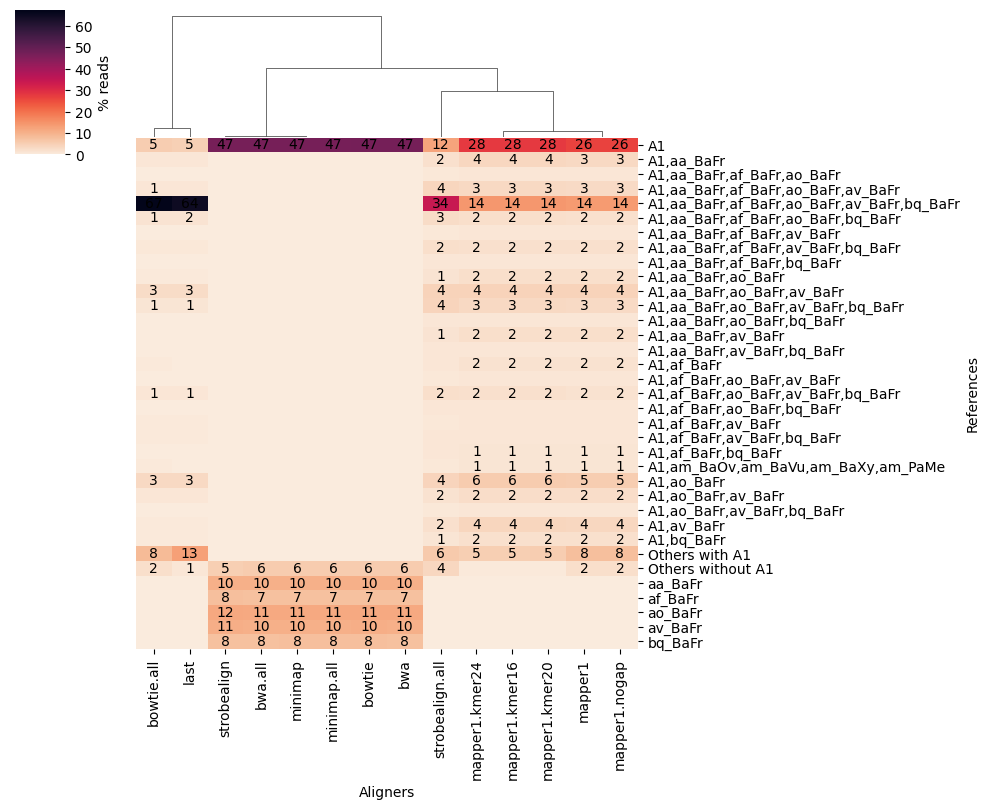

In [38]:
if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=True, #center=0.3, 
                       row_cluster=False,
                       figsize=(10,8), yticklabels=True,
                       cbar_kws={'ticks': np.linspace(0, 
                                                      70, num=8), 'label': '% reads'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val > 1:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.0f}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('References')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('SNP_model_multi/all_1.fastq_Bactor.countsum2.pdf')


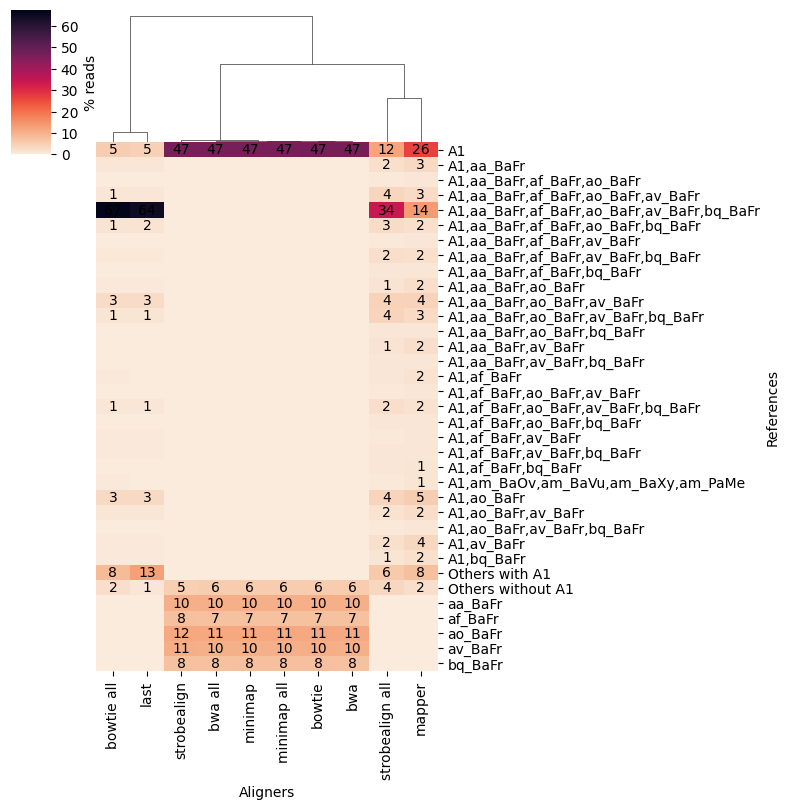

In [39]:
ref_combinations_count3 = ref_combinations_count3.loc[:,['bowtie','bowtie.all',
                                                         'strobealign','strobealign.all',
                                                         'last',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all',
                                                       'mapper1',
                                                      ]]
ref_combinations_count3.columns = [x.replace('mapper1','mapper').replace('.',' ') for x in ref_combinations_count3.columns]

if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=True, #center=0.3, 
                       row_cluster=False,
                       figsize=(8,8), yticklabels=True,
                       cbar_kws={'ticks': np.linspace(0, 
                                                      70, num=8), 'label': '% reads'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val > 1:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.0f}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('References')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('SNP_model_multi/all_1.fastq_Bactor.countsum.pdf')


In [30]:
ref_combinations_count3 = ref_combinations_count.loc[ref_combinations_count2.sum(axis = 1)>=5,:]
ref_combinations_count4 = ref_combinations_count.loc[ref_combinations_count2.sum(axis = 1)<5,:]
ref_combinations_count3 = ref_combinations_count3.T
ref_combinations_count3['Others with A1'] = 0
ref_combinations_count3['Others without A1'] = 0
ref_combinations_count3 = ref_combinations_count3.T
for tool in ref_combinations_count4.columns:
    ref_combinations_count4sub = ref_combinations_count4.loc[ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others with A1',tool] = sum(ref_combinations_count4sub)
    ref_combinations_count4sub = ref_combinations_count4.loc[~ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others without A1',tool] = sum(ref_combinations_count4sub)
ref_combinations_count3 = ref_combinations_count3.sort_index()
ref_combinations_count3.tail()


,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,strobealign.all,strobealign,last,mapper1,mapper1.nogap,mapper1.kmer16,mapper1.kmer20,mapper1.kmer24
reference,,,,,,,,,,,,,,
aa_BaFr,335615.0,572.0,336988.0,337064.0,340315.0,339765.0,4885.0,335603.0,197.0,2534.0,2482.0,3052.0,3062.0,3104.0
af_BaFr,239738.0,518.0,243241.0,243244.0,243777.0,243444.0,4815.0,252886.0,396.0,1787.0,1750.0,2509.0,2476.0,2479.0
ao_BaFr,369717.0,377.0,370338.0,370401.0,373978.0,373360.0,6452.0,372596.0,138.0,3469.0,3439.0,3977.0,3976.0,4105.0
av_BaFr,340357.0,654.0,340902.0,340893.0,338085.0,337575.0,6097.0,343925.0,290.0,3313.0,3212.0,3697.0,3742.0,3801.0
bq_BaFr,247750.0,456.0,248751.0,248770.0,247603.0,247102.0,3751.0,243949.0,162.0,2264.0,2261.0,2834.0,2826.0,2890.0


In [43]:
# check sam ref coverage
folder = 'SNP_model_multi/bowtie/'
# load ref
from Bio import SeqIO
ref_len = {}
for record in SeqIO.parse('test_data/multi_Genome/Bactor/all_final.scaffolds.fasta','fasta'):
    species = str(record.id).split('_sca')[0].split('_NODE')[0]
    ref_len.setdefault(species,0)
    ref_len[species] += len(str(record.seq))
ref_len


{'aa_BaCe': 3833540,
 'aa_BaDo': 5681194,
 'aa_BaFa': 6268938,
 'aa_BaFr': 5349002,
 'aa_BaOv': 6633912,
 'aa_BaVu': 5199152,
 'aa_BaXy': 6432453,
 'af_BaCe': 5314253,
 'af_BaDo': 5843668,
 'af_BaFr': 5275351,
 'af_BaSt': 4193667,
 'af_BaTh': 6701940,
 'af_BaUn': 4970798,
 'af_BaVu': 5507646,
 'af_BaXy': 6406153,
 'am_AkMu': 2876208,
 'am_AlOn': 3537260,
 'am_BaFr': 5204643,
 'am_BA': 2079252,
 'am_BaOv': 6742449,
 'am_BaSa': 5831116,
 'am_BaSt': 3640259,
 'am_BaVu': 5319488,
 'am_BaXy': 6663961,
 'am_BiPs': 2227668,
 'am_BL': 2403024,
 'am_BlOb': 3393963,
 'am_BlSp': 3524598,
 'am_CoAe': 2215905,
 'am_EnCl': 5264149,
 'am_EnDu': 3088964,
 'am_EnMu': 3384881,
 'am_EsCo': 5995805,
 'am_FaCy': 3278931,
 'am_FiSp': 1835172,
 'am_FlPl': 4595415,
 'am_HoMa': 4123339,
 'am_LaSp': 4923238,
 'am_PaDi': 5204877,
 'am_PaEx': 3241286,
 'am_PaMe': 4946021,
 'am_PhFa': 2443602,
 'am_PrMi': 3970443,
 'am_PrNa': 3004562,
 'am_RuLa': 4524086,
 'am_RuTo': 2950825,
 'am_StSa': 2378423,
 'am_TuSa': 42841

In [44]:
import datetime
ref_covsumall = pd.DataFrame()
read_len = 150
def is_read_reverse_strand(flag):
    return bool(flag & 16)

for samfile in glob.glob('%s/all*sam'%(folder)):
    print(datetime.datetime.now(), 'process ',samfile)
    tool = os.path.basename(samfile).split('Bactor.')[1].split('.sam')[0]
    sam1 = ''
    sam1 = pd.read_csv(samfile,sep='\t')
    print(datetime.datetime.now(), 'done reading ',samfile)
    ref_cov = {}
    allCHRPOS = set()
    for i in sam1.index:
        direction = is_read_reverse_strand(sam1.loc[i,'Direction'])
        CHR = sam1.loc[i,'CHR']
        POS = sam1.loc[i,'POS']
        CHRPOS = '%s\t%s'%(CHR,POS)
        if i%1000000 == 0:
            print(datetime.datetime.now(), 'process %s lines'%(i))
        if CHRPOS not in allCHRPOS:
            species = CHR.split('_sca')[0].split('_NODE')[0]
            ref_cov_species = ref_cov.get(species,{})
            ref_cov_species.setdefault(CHR,set())
            ref_cov_species[CHR].add(POS)
            if direction:
                for POS2 in range(max(POS-read_len,0),POS):
                    ref_cov_species[CHR].add(POS2)
            else:
                for POS2 in range(POS,POS+read_len):
                    ref_cov_species[CHR].add(POS2)
            ref_cov[species] =  ref_cov_species  
            allCHRPOS.add(CHRPOS)
    ref_cov2 = {}
    for species in ref_cov:
        ref_cov2.setdefault(species,0)
        for CHR in ref_cov[species]:
            ref_cov2[species] += len(ref_cov[species][CHR])
    for species in ref_cov:
        ref_cov2[species]=ref_cov2[species]/ref_len[species]
    ref_covsum = pd.DataFrame(ref_cov2,index = range(0,1))
    ref_covsum = ref_covsum.T
    ref_covsum['tool'] = tool
    ref_covsumall = ref_covsumall.append(ref_covsum)
    ref_covsumall.to_csv('SNP_model_multi/cov_sum.txt',sep='\t',mode = 'a')
    

2024-10-14 14:32:58.724328 process  SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.sam
2024-10-14 14:33:03.825282 done reading  SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.sam
2024-10-14 14:33:03.833578 process 0 lines
2024-10-14 14:33:17.488211 process 1000000 lines
2024-10-14 14:33:29.941200 process 2000000 lines
2024-10-14 14:33:42.103429 process 3000000 lines
2024-10-14 14:33:53.984039 process 4000000 lines
2024-10-14 14:34:05.033072 process 5000000 lines
2024-10-14 14:34:16.162435 process 6000000 lines
2024-10-14 14:34:27.115956 process 7000000 lines
2024-10-14 14:34:38.147814 process 8000000 lines
2024-10-14 14:34:49.100573 process 9000000 lines
2024-10-14 14:34:59.903991 process 10000000 lines
2024-10-14 14:35:10.543747 process 11000000 lines
2024-10-14 14:35:21.169180 process 12000000 lines
2024-10-14 14:35:31.773826 process 13000000 lines
2024-10-14 14:35:42.219301 process 14000000 lines
2024-10-14 14:35:47.150121 process  SNP_model_multi/bowtie/all_1.fastq_Bactor.bow

In [69]:
# plot
allcount = glob.glob('SNP_model_multi/bowtie/all_1.fastq_Bactor.*sam.count')
ref_combinations_count = pd.DataFrame()
for countfile in allcount:
    print(countfile)
    tool = os.path.basename(countfile).split('.sam')[0].split('all_1.fastq_Bactor.')[1]
    countsum = pd.read_csv(countfile, 
                             sep='\t')
    countsum.columns = ['reference',tool]
    if ref_combinations_count.shape[0] == 0:
        ref_combinations_count = countsum
    else:
        ref_combinations_count = ref_combinations_count.merge(countsum,
                                                              left_on = 'reference',right_on = 'reference',how  = 'outer')

# ref_combinations_count.to_csv('/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.countsum',sep='\t',index = False)
ref_combinations_count['reference'] = [x.replace('am_BaFr','A1') for x in ref_combinations_count['reference']]
ref_combinations_count = ref_combinations_count.sort_values('reference')
ref_combinations_count.index = ref_combinations_count['reference']
ref_combinations_count=ref_combinations_count.iloc[:,1:]
ref_combinations_count = ref_combinations_count.loc[:,['bowtie','bowtie.all',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all','strobealign.all','strobealign','last',
                                                       'mapper1','mapper1.nogap','mapper1.kmer16','mapper1.kmer20','mapper1.kmer24'
                                                      ]]
ref_combinations_count[ref_combinations_count.isna()]=0
ref_combinations_count = ref_combinations_count.sort_index()
ref_combinations_count


SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer20.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.strobealign.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.last.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.minimap.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer24.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer25.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.strobealign.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer16.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.all.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.minimap.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.nogap.sam.count
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.sam.count


,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,strobealign.all,strobealign,last,mapper1,mapper1.nogap,mapper1.kmer16,mapper1.kmer20,mapper1.kmer24
reference,,,,,,,,,,,,,,
A1,1526853.0,173898.0,1526705.0,1526960.0,1531830.0,1529800.0,392437.0,1507094.0,157600.0,863327.0,862758.0,860085.0,859665.0,858017.0
"A1,aa_BaCe",0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaCe,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx_BaOv,8265.0,0.0,9381.0,8889.0,7765.0,6372.0,4650.0,5867.0,16.0,26.0,48.0,16.0,21.0,27.0
"cx_BaOv,cx_BaVu",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
cx_BaUn,1444.0,0.0,1418.0,1485.0,1508.0,1504.0,10.0,1486.0,0.0,18.0,35.0,51.0,56.0,62.0


In [70]:
import copy
ref_combinations_count2 = copy.deepcopy(ref_combinations_count)
ref_combinations_countcolsum = ref_combinations_count.sum(axis=0)
for i in ref_combinations_count2.columns:
    ref_combinations_count2.loc[:,i]=ref_combinations_count2.loc[:,i]/sum(ref_combinations_count2.loc[:,i])*100
ref_combinations_count2

,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,strobealign.all,strobealign,last,mapper1,mapper1.nogap,mapper1.kmer16,mapper1.kmer20,mapper1.kmer24
reference,,,,,,,,,,,,,,
A1,47.050175,5.293355,46.868146,46.879471,46.968480,46.813869,12.070803,46.667059,4.972638,26.373773,26.371303,27.576992,27.583238,27.592564
"A1,aa_BaCe",0.000000,0.000000,0.000000,0.000000,0.000000,0.000031,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaCe,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cx_BaOv,0.254687,0.000000,0.287986,0.272903,0.238088,0.194991,0.143027,0.181671,0.000505,0.000794,0.001467,0.000513,0.000674,0.000868
"cx_BaOv,cx_BaVu",0.000000,0.000000,0.000000,0.000000,0.000031,0.000000,0.000031,0.000031,0.000095,0.000000,0.000000,0.000000,0.000000,0.000000
cx_BaUn,0.044497,0.000000,0.043531,0.045591,0.046238,0.046024,0.000308,0.046014,0.000000,0.000550,0.001070,0.001635,0.001797,0.001994


In [71]:
ref_combinations_count2_A1 = ref_combinations_count2.loc[ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_noA1 = ref_combinations_count2.loc[~ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_A1.sum(axis = 0).sort_values()


strobealign        46.797452
minimap            46.971846
minimap.all        46.983210
bwa                47.038910
bwa.all            47.103082
bowtie             47.148106
strobealign.all    95.551264
mapper1.nogap      97.416691
mapper1            97.446623
bowtie.all         97.636135
last               98.937540
mapper1.kmer24     99.072902
mapper1.kmer16     99.087035
mapper1.kmer20     99.090778
dtype: float64

In [72]:
ref_combinations_count2_noA1.sum(axis = 0).sort_values()


mapper1.kmer20      0.909222
mapper1.kmer16      0.912965
mapper1.kmer24      0.927098
last                1.062460
bowtie.all          2.363865
mapper1             2.553377
mapper1.nogap       2.583309
strobealign.all     4.448736
bowtie             52.851894
bwa.all            52.896918
bwa                52.961090
minimap.all        53.016790
minimap            53.028154
strobealign        53.202548
dtype: float64

In [73]:
ref_combinations_count2_A1 = ref_combinations_count2.loc[ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_noA1 = ref_combinations_count2.loc[~ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_A1.sum(axis = 0).sort_values()
ref_covsumall = pd.read_csv('SNP_model_multi/cov_sum.txt',sep='\t')
ref_covsumall.columns = ['Genome','Cov','tool']
ref_covsumall.loc[ref_covsumall['Cov']>=1,'Cov']=1
ref_cov = pd.DataFrame(
index = ref_covsumall['Genome'].unique(),
    columns = ref_covsumall['tool'].unique(),
)
for i in ref_covsumall.index:
    ref_cov.loc[ref_covsumall.loc[i,'Genome'],
                ref_covsumall.loc[i,'tool']
               ] = float(ref_covsumall.loc[i,'Cov'])
ref_cov.replace('NaN',0,inplace=True)
ref_cov[ref_cov<0.05]=0
ref_cov = pd.DataFrame(ref_cov)
# ref_cov.columns = [x.replace('kmer24','kmer25') for x in ref_cov.columns]
# cov cutoff 0.05
for tool in ref_combinations_count2_A1.columns:
    if tool != 'ref':
        for reference in ref_combinations_count2_A1.index:
            referenceset = reference.split(',')
            i = 0
            for genome in referenceset:
                if genome == 'A1' or ref_cov.loc[genome,tool] > 0:
                    i+=1
            ref_combinations_count2_A1.loc[reference,tool] = ref_combinations_count2_A1.loc[reference,tool]/i
ref_combinations_count2_A1.sum(axis = 0).sort_values()



last               22.627107
bowtie.all         23.512402
strobealign.all    35.433782
strobealign        46.735244
bwa.all            46.894318
minimap            46.923961
minimap.all        46.935352
bwa                47.007602
bowtie             47.102376
mapper1.nogap      49.873733
mapper1            49.887636
mapper1.kmer16     50.674533
mapper1.kmer24     50.684046
mapper1.kmer20     50.684186
dtype: float64

In [74]:
ref_combinations_count2.columns

Index(['bowtie', 'bowtie.all', 'minimap', 'minimap.all', 'bwa', 'bwa.all',
       'strobealign.all', 'strobealign', 'last', 'mapper1', 'mapper1.nogap',
       'mapper1.kmer16', 'mapper1.kmer20', 'mapper1.kmer24'],
      dtype='object')

In [75]:
ref_covsumall = pd.read_csv('SNP_model_multi/cov_sum.txt',sep='\t')
ref_covsumall.columns = ['Genome','Cov','tool']
ref_covsumall.loc[ref_covsumall['Cov']>=1,'Cov']=1
ref_covsumall = ref_covsumall[ref_covsumall['tool']!='tool']
ref_cov = pd.DataFrame(
index = ref_covsumall['Genome'].unique(),
    columns = ref_covsumall['tool'].unique(),
)
for i in ref_covsumall.index:
    ref_cov.loc[ref_covsumall.loc[i,'Genome'],
                ref_covsumall.loc[i,'tool']
               ] = float(ref_covsumall.loc[i,'Cov'])
ref_cov = ref_cov.loc[~ref_cov.index.isna(),:]
ref_cov.replace('NaN',0,inplace=True)
ref_cov[ref_cov<0.05]=0
ref_cov = pd.DataFrame(ref_cov)

ref_cov.index = [x.replace('am_BaFr','A1') for x in ref_cov.index]
ref_abu = copy.deepcopy(ref_cov)
# cov cutoff 0.05
for tool in ref_abu.columns:
        ref_abu[tool]=0
        for reference in ref_combinations_count2.index:
            referenceset = reference.split(',')
            i = 0
            for genome in referenceset:
                if genome == 'A1' or ref_cov.loc[genome,tool] > 0:
                    i+=1
            if i > 0:
                for genome in referenceset:
                    ref_abu.loc[genome,tool] += ref_combinations_count2.loc[reference,tool]/i
ref_abu[ref_abu.isna()]=0
ref_abu.to_csv('SNP_model_multi/abu_0.05.txt',sep='\t')
ref_abu.head()



,mapper1,bowtie.all,mapper1.kmer16,strobealign.all,last,strobealign,mapper1.kmer24,bowtie,bwa.all,mapper1.kmer20,minimap.all,mapper1.nogap,bwa,minimap
A1,49.887636,23.512402,50.674533,35.433782,22.627107,46.735244,50.684046,47.102376,46.894318,50.684186,46.935352,49.873733,47.007602,46.923961
ao_BaFr,11.663071,15.492840,11.843355,14.510714,15.411892,11.574319,11.841918,11.422784,11.485083,11.842521,11.401118,11.658279,11.487002,11.398748
aa_BaFr,11.168574,14.048037,10.735019,13.557195,13.890423,10.426743,10.731201,10.369631,10.451926,10.732708,10.376911,11.152995,10.452216,10.373927
bq_BaFr,7.606404,12.929882,7.958714,10.910508,12.957812,7.581933,7.955460,7.654725,7.608416,7.957064,7.659678,7.605906,7.605785,7.658646
av_BaFr,10.401176,13.995807,10.876223,13.125663,13.981901,10.688288,10.876414,10.518576,10.383380,10.877169,10.495111,10.398354,10.384084,10.494819


In [76]:
ref_abu = pd.read_csv('SNP_model_multi/abu_0.05.txt',sep='\t')
ref_abu.index = ref_abu['Unnamed: 0']
ref_abu = ref_abu.loc[:,['bowtie','bowtie.all','strobealign.all','strobealign','last',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all',
                                                       'mapper1',
                                                      ]]
ref_abu.head()

,bowtie,bowtie.all,strobealign.all,strobealign,last,minimap,minimap.all,bwa,bwa.all,mapper1
Unnamed: 0,,,,,,,,,,
A1,47.102376,23.512402,35.433782,46.735244,22.627107,46.923961,46.935352,47.007602,46.894318,49.887636
ao_BaFr,11.422784,15.492840,14.510714,11.574319,15.411892,11.398748,11.401118,11.487002,11.485083,11.663071
aa_BaFr,10.369631,14.048037,13.557195,10.426743,13.890423,10.373927,10.376911,10.452216,10.451926,11.168574
bq_BaFr,7.654725,12.929882,10.910508,7.581933,12.957812,7.658646,7.659678,7.605785,7.608416,7.606404
av_BaFr,10.518576,13.995807,13.125663,10.688288,13.981901,10.494819,10.495111,10.384084,10.383380,10.401176


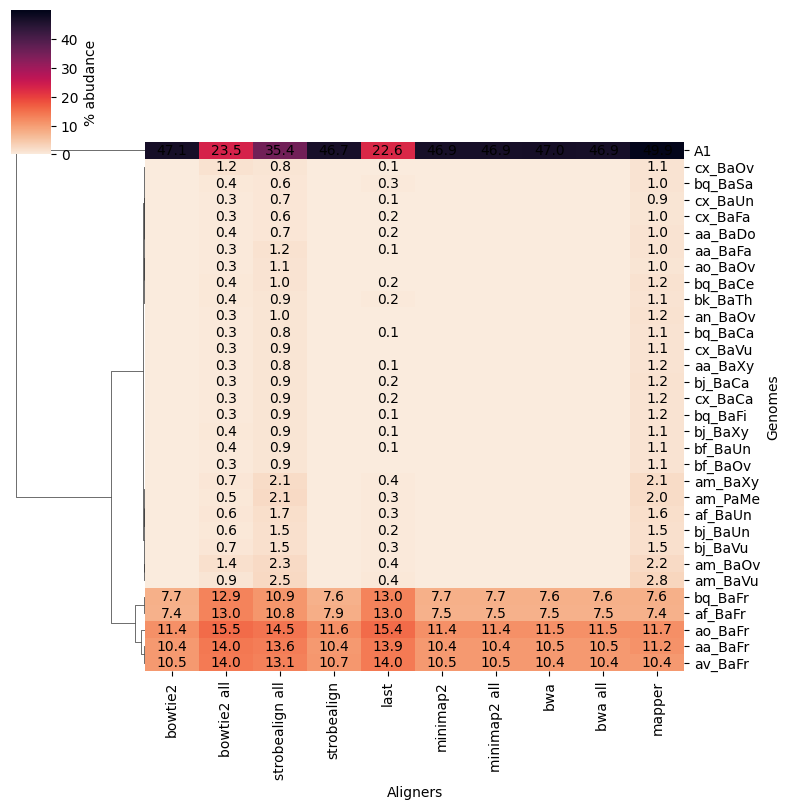

In [83]:
ref_combinations_count3 = ref_abu.loc[:,['bowtie','bowtie.all','strobealign.all','strobealign','last',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all',
                                                       'mapper1',
                                                      ]]
ref_combinations_count3.columns = [x.replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2').replace('.all',' all') for x in ref_combinations_count3.columns]
ref_combinations_count3 = ref_combinations_count3.loc[ref_combinations_count3.sum(axis = 1)>=2,:]

if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=False, #center=0.3, 
                       row_cluster=True,
                       figsize=(8,8), 
                       yticklabels=True,
                       cbar_kws={'ticks': np.linspace(0, 
                                                      50, num=6), 'label': '% abudance'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val >= 0.1:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.1f}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('Genomes')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('SNP_model_multi/all_1.fastq_Bactor.cov0.05.pdf')


In [81]:
ref_combinations_count3 = ref_combinations_count2.loc[ref_combinations_count2.sum(axis = 1)>=5,:]
ref_combinations_count4 = ref_combinations_count2.loc[ref_combinations_count2.sum(axis = 1)<5,:]
ref_combinations_count3 = ref_combinations_count3.T
ref_combinations_count3['Others with A1'] = 0
ref_combinations_count3['Others without A1'] = 0
ref_combinations_count3 = ref_combinations_count3.T
for tool in ref_combinations_count4.columns:
    ref_combinations_count4sub = ref_combinations_count4.loc[ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others with A1',tool] = sum(ref_combinations_count4sub)
    ref_combinations_count4sub = ref_combinations_count4.loc[~ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others without A1',tool] = sum(ref_combinations_count4sub)
ref_combinations_count3 = ref_combinations_count3.sort_index()
ref_combinations_count3.tail()


,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,strobealign.all,strobealign,last,mapper1,mapper1.nogap,mapper1.kmer16,mapper1.kmer20,mapper1.kmer24
reference,,,,,,,,,,,,,,
aa_BaFr,10.342020,0.017411,10.345157,10.348262,10.434629,10.397251,0.150256,10.391923,0.006216,0.077411,0.075866,0.097857,0.098247,0.099820
af_BaFr,7.387558,0.015768,7.467228,7.467877,7.474612,7.449703,0.148103,7.830597,0.012495,0.054591,0.053491,0.080446,0.079445,0.079721
ao_BaFr,11.392878,0.011476,11.368965,11.371747,11.466793,11.425301,0.198454,11.537409,0.004354,0.105974,0.105117,0.127515,0.127574,0.132011
av_BaFr,10.488146,0.019907,10.465312,10.465817,10.366254,10.330234,0.187535,10.649613,0.009150,0.101209,0.098179,0.118537,0.120066,0.122235
bq_BaFr,7.634449,0.013880,7.636379,7.637532,7.591924,7.561642,0.115375,7.553863,0.005111,0.069163,0.069110,0.090867,0.090675,0.092938


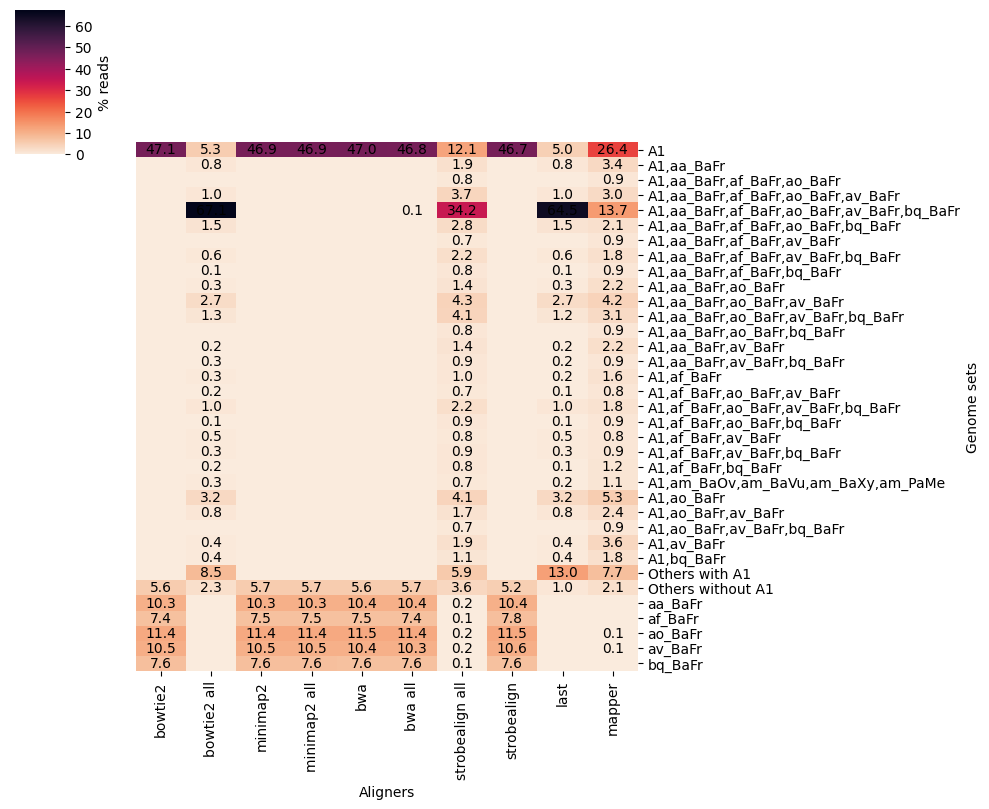

In [82]:
ref_combinations_count3 = ref_combinations_count3.loc[:,['bowtie','bowtie.all',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all','strobealign.all','strobealign','last',
                                                       'mapper1',
                                                      ]]
ref_combinations_count3.columns = [x.replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2').replace('.all',' all') for x in ref_combinations_count3.columns]

if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=False, #center=0.3, 
                       row_cluster=False,
                       figsize=(10,8), yticklabels=True,
                       cbar_kws={'ticks': np.linspace(0, 
                                                      70, num=8), 'label': '% reads'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val > 0.1:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.1f}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('Genome sets')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('SNP_model_multi/all_1.fastq_Bactor.countsum.pdf')
